In [2]:
import os
from PIL import Image
import glob
from IPython.display import display, HTML
import base64
from io import BytesIO
import cv2
from pathlib import Path
import numpy as np
from sklearn.metrics import mean_squared_error

In [3]:
%cd yolov5/

c:\Users\ARISH\Desktop\2nd_final\yolov5


Validating the Images on Train model

In [4]:
!python val.py --weights runs/train/license_plate_detector/weights/best.pt --data data.yaml --img 640 --save-txt --save-conf

val: data=data.yaml, weights=['runs/train/license_plate_detector/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-366-gf7322921 Python-3.10.14 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

val: Scanning C:\Users\ARISH\Desktop\2nd_final\yolov5\custom_data\val\labels.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]
val: Scanning C:\Users\ARISH\Desktop\2nd_final\yolov5\custom_data\val\labels.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   

Below is the metrics for Validation Images


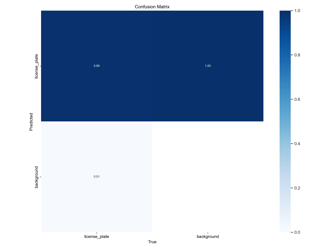
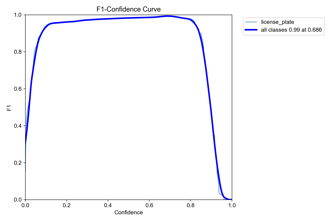
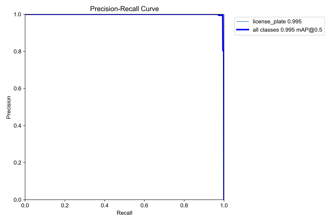
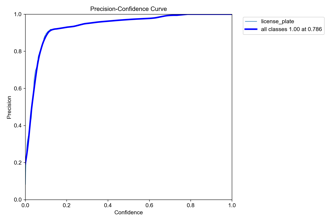
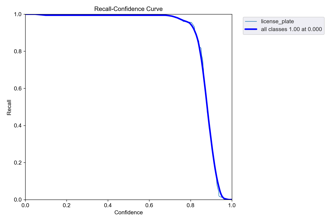
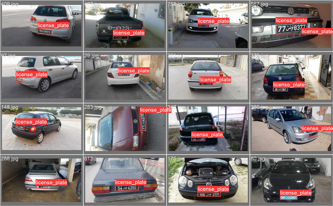
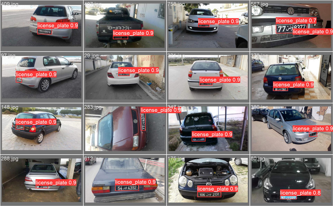
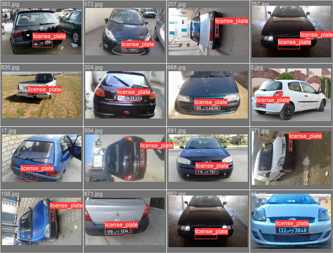
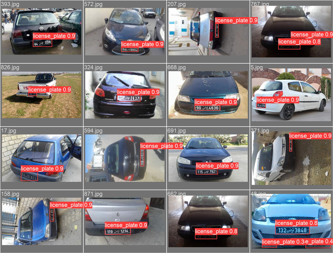
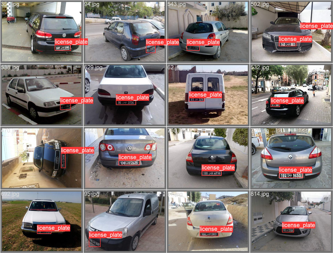
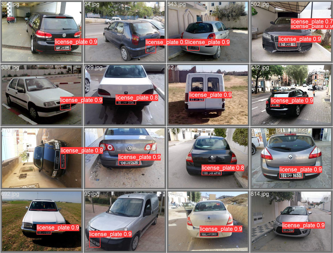

In [5]:
# Define the directory path and file extensions
image_dir = 'runs/val/exp'
image_extensions = ['*.png', '*.jpg']

# Collect all image paths
image_list = []
for ext in image_extensions:
    image_list.extend(glob.glob(os.path.join(image_dir, ext)))

# Parameters for resizing
max_width = 1000  # Maximum width for display
images_per_row = 3

# Create an HTML string to display images
html_str = '<div style="display: flex; flex-wrap: wrap;">'
for i, image_name in enumerate(image_list):
    # Load and resize image
    img = Image.open(image_name)
    width, height = img.size
    new_width = max_width // images_per_row
    new_height = int(height * (new_width / width))
    img = img.resize((new_width, new_height))

    # Convert image to base64
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode()

    # Add image to HTML string
    html_str += '<div style="margin: 10px;"><img src="data:image/png;base64,{}" width="{}" height="{}"></div>'.format(img_base64, new_width, new_height)

html_str += '</div>'

# Display HTML string
display(HTML(html_str))


Converting the label from the validated data into csv format and saving it for model evaluation

In [6]:
# Paths
detected_labels_path = Path('runs/val/exp/labels')
validation_images_path = Path('custom_data/val/images')

# List all label files
label_files = list(detected_labels_path.glob('*.txt'))

results = []

for label_file in label_files:
    img_id = label_file.stem
    img_path = validation_images_path / f"{img_id}.jpg"  # or .png based on your file extension
    img = cv2.imread(str(img_path))

    # Read detection results from the label file
    with open(label_file, 'r') as file:
        detections = [line.strip().split() for line in file.readlines()]

    if detections:
        # Keep only the most confident detection
        best_detection = max(detections, key=lambda x: float(x[5]))
        class_id, x_center, y_center, width, height, confidence = best_detection

        # Convert YOLO format to (ymin, xmin, ymax, xmax)
        img_height, img_width = img.shape[:2]
        x_center = float(x_center) * img_width
        y_center = float(y_center) * img_height
        width = float(width) * img_width
        height = float(height) * img_height

        xmin = int(x_center - width / 2)
        ymin = int(y_center - height / 2)
        xmax = int(x_center + width / 2)
        ymax = int(y_center + height / 2)

        # Save result
        results.append([f"{img_id}.jpg", xmin, ymin, xmax, ymax])

# Save results to a CSV file
results_df = pd.DataFrame(results, columns=['img_id', 'xmin', 'ymin', 'xmax', 'ymax'])
results_df.to_csv('runs/val/detected_license_plates.csv', index=False)

Model evaluation metrics

In [7]:
val_df = pd.read_csv("custom_data/val/Licplatesdetection_val.csv")
detected_df = pd.read_csv('runs/val/detected_license_plates.csv')

# Merge the data on img_id
merged_df = pd.merge(val_df, detected_df, on='img_id', suffixes=('_actual', '_predicted'))

# Calculate Mean Squared Error (MSE) for the bounding box coordinates
mse_xmin = mean_squared_error(merged_df['xmin_actual'], merged_df['xmin_predicted'])
mse_ymin = mean_squared_error(merged_df['ymin_actual'], merged_df['ymin_predicted'])
mse_xmax = mean_squared_error(merged_df['xmax_actual'], merged_df['xmax_predicted'])
mse_ymax = mean_squared_error(merged_df['ymax_actual'], merged_df['ymax_predicted'])

print(f"MSE for xmin: {mse_xmin}")
print(f"MSE for ymin: {mse_ymin}")
print(f"MSE for xmax: {mse_xmax}")
print(f"MSE for ymax: {mse_ymax}")

# Calculate the overall accuracy (IOU - Intersection Over Union)
def iou(box1, box2):
    # box1 and box2 should be in [xmin, ymin, xmax, ymax] format
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    intersection_area = max(0, x_max - x_min) * max(0, y_max - y_min)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area
    return iou

# Calculate the IOU for each image
merged_df['iou'] = merged_df.apply(lambda row: iou(
    [row['xmin_actual'], row['ymin_actual'], row['xmax_actual'], row['ymax_actual']],
    [row['xmin_predicted'], row['ymin_predicted'], row['xmax_predicted'], row['ymax_predicted']]
), axis=1)

average_iou = merged_df['iou'].mean()
print(f"Average IOU: {average_iou}")

# Calculate Precision, Recall, and F1-score
def calculate_tp_fp_fn(merged_df, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0

    for index, row in merged_df.iterrows():
        if row['iou'] >= iou_threshold:
            tp += 1
        else:
            fp += 1

    fn = len(merged_df) - tp

    return tp, fp, fn

tp, fp, fn = calculate_tp_fp_fn(merged_df)

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")

# Calculate Mean Average Precision (mAP)
def calculate_map(merged_df, iou_threshold=0.5):
    ap_values = []
    for recall_level in np.arange(0, 1.1, 0.1):
        tp, fp, fn = calculate_tp_fp_fn(merged_df, iou_threshold)
        precision = tp / (tp + fp)
        ap_values.append(precision)

    map_value = np.mean(ap_values)
    return map_value

map_value = calculate_map(merged_df)
print(f"Mean Average Precision (mAP): {map_value}")

MSE for xmin: 11.544444444444444
MSE for ymin: 6.55
MSE for xmax: 12.427777777777777
MSE for ymax: 8.477777777777778
Average IOU: 0.8761397376763997
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Mean Average Precision (mAP): 1.0
